In [80]:
import gc
import re
import joblib
import operator
import string
from collections import defaultdict
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings #to modify warnings
warnings.filterwarnings('ignore') #ignoring warnings
sns.set_style('darkgrid')

from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

In [81]:
train = pd.read_csv('/kaggle/input/penyisihan-datavidia-7-0/train.csv')
test = pd.read_csv('/kaggle/input/penyisihan-datavidia-7-0/test.csv')
train.head()

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


In [82]:
def create_corpus(data, var):
    corpus=[]
    
    for x in data[var].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def get_data_contains_word(data, feature, string) :
    _id = []
    for text,ID in zip(data[feature], data['review_id']) :
        if string in text :
            _id.append(ID)
    return data[data['review_id'].isin(_id)]

def remove_indonesian_stop(data, feature) :
    stopwords = fix_stopwords
    filtered = []
    for text in data[feature] :
        text_list = []
        for word in text.split() :
            if word not in stopwords :
                text_list.append(word)
        text_list = ' '.join(text_list)
        filtered.append(text_list)
    return filtered

def docs_contain_word_plot(data, var, num_words, width, height) :
    # data berupa df
    words = []
    counts = []
    corpus = create_corpus(data, var)
    corpus = list(set(corpus))
    for word in tqdm(corpus) :
        words.append(word)
        counts.append(get_data_contains_word(data, var, word).shape[0])
    
    res = pd.DataFrame({'words' : words,
                        'counts' : counts})
    res = res.sort_values(by = 'counts', ascending = False)
    plt.figure(figsize = [width, height])
    sns.barplot(data = res.iloc[:num_words],
                x = 'counts',
                y = 'words')
    for index, value in enumerate(res['counts'].iloc[:num_words]) :
        plt.text(value, index, value)
    plt.show()
    
def num_count(data, feature) :
    #kompas_list = list(set(kompas['words']))
    num_list = []
    for sentence in tqdm(data[feature]) :
        num = 0
        for word in sentence :
            if word.isdigit() :
                num += 1
            else :
                num += 0
        num_list.append(num)
    return num_list

def plot_unique_word_count(corpus, width, height, range1, range2, title, color, ax = None) :
    words = []
    values = []
    len_words = []
    for word, value in zip(pd.DataFrame(corpus).value_counts().index, pd.DataFrame(corpus).value_counts()) :
        words.append(word[0])
        values.append(value)
        len_words.append(len(word[0]))
    res = pd.DataFrame({'words' : words,
                        'values' : values,
                        'len_words' : len_words})
    res = res.sort_values(by = 'values', ascending = False)
    #plt.figure(figsize = [width, height])
    ax = ax
    ax.set_title(title)
    sns.barplot(data = res[range1:range2],
                y = 'words',
                x = 'values',
                color = color,
                ax = ax)
    for index, value in enumerate(res['values'].iloc[range1:range2]) :
        plt.text(value, index, value)
    #plt.show()
    
    return ax

def df_unique_word_count(corpus) :
    words = []
    values = []
    len_words = []
    for word, value in zip(pd.DataFrame(corpus).value_counts().index, pd.DataFrame(corpus).value_counts()) :
        words.append(word[0])
        values.append(value)
        len_words.append(len(word[0]))
    res = pd.DataFrame({'words' : words,
                        'values' : values,
                        'len_words' : len_words})
    res = res.sort_values(by = 'values', ascending = False)
    return res

### INDONESIAN STOPWORDS

In [83]:
stopwords = ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'setelah', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'apakah', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 'sebetulnya', 'setiap', 'setidaknya', 'sesuatu', 'pasti', 'saja', 'toh', 'ya', 'walau', 'tolong', 'tentu', 'amat', 'apalagi', 'bagaimanapun', 'sekali', 'jadi', 'nya']
keep_stopwords = ['tidak', 'sementara', 'belum', 'tetapi', 'kecuali', 'tapi', 'ada', 'tanpa', 'nggak', 'ok', 'hanya', 'kurang']
fix_stopwords = [next if word in keep_stopwords else word for word in stopwords]

### Typo Words Dictionary

In [84]:
words_dict = {
    'tdk'  : 'tidak',
    'yg' : 'yang',
    'ga' : 'tidak',
    'gak' : 'tidak',
    'tp' : 'tapi',
    'd' : 'di',
    'sy' : 'saya',
    '&' : 'dan',
    'dgn' : 'dengan', 
    'utk' : 'untuk',
    'gk' : 'tidak',
    'jd' : 'jadi',
    'jg' : 'juga',
    'dr' : 'dari',
    'krn' : 'karena',
    'aja' : 'saja',
    'karna' : 'karena',
    'udah' : 'sudah',
    'kmr' : 'kamar',
    'g' : 'tidak',
    'dpt' : 'dapat',
    'banget' : 'sekali',
    'bgt' : 'sekali',
    'kalo' : 'kalau',
    'n' : 'dan', 
    'bs' : 'bisa',
    'oke' : 'ok',
    'dg' : 'dengan',
    'pake' : 'pakai',
    'sampe' : 'sampai',
    'dapet' : 'dapat',
    'ad' : 'ada',
    'lg' : 'lagi',
    'bikin' : 'buat',
    'tak' : 'tidak',
    'ny' : 'nya',
    'ngga' : 'tidak',
    'nunggu' : 'tunggu',
    'klo' : 'kalau',
    'blm' : 'belum',
    'trus' : 'terus',
    'kayak' : 'seperti',
    'dlm' : 'dalam',
    'udh' : 'sudah',
    'tau' : 'tahu',
    'org' : 'orang',
    'hrs' : 'harus',
    'msh' : 'masih',
    'sm' : 'sama',
    'byk' : 'banyak',
    'krg' : 'kurang',
    'kmar' : 'kamar',
    'spt' : 'seperti',
    'pdhl' : 'padahal',
    'chek' : 'cek',
    'pesen' : 'pesan', 
    'kran' : 'keran',
    'gitu' : 'begitu',
    'tpi' : 'tapi',
    'lbh' : 'lebih',
    'tmpt' : 'tempat',
    'dikasi' : 'dikasih',
    'serem' : 'seram', 
    'sya' : 'saya',
    'jgn' : 'jangan',
    'dri' : 'dari',
    'dtg' : 'datang',
    'gada' : 'tidak ada',
    'standart' : 'standar',
    'mlm' : 'malam',
    'k'  : 'ke',
    'kl' : 'kalau',
    'sgt': 'sangat',
    'y' : 'ya',
    'krna' : 'karena',
    'tgl' : 'tanggal', 
    'terimakasih' : 'terima kasih',
    'kecoak' : 'kecoa',
    'pd' : 'pada',
    'tdr' : 'tidur', 
    'jdi' : 'jadi',
    'kyk' : 'seperti',
    'sdh' : 'sudah',
    'ama' : 'sama',
    'gmana' : 'bagaimana',
    'dalem' : 'dalam',
    'tanyak' : 'tanya',
    'taru' : 'taruh',
    'gede' : 'besar',
    'kaya' : 'seperti',
    'access' : 'akses',
    'tetep' : 'tetap',
    'mgkin' : 'mungkin',
    'sower' : 'shower',
    'idup' : 'hidup',
    'nyaaa' : 'nya',
    'baikk' : 'baik',
    'hanay' : 'hanya',
    'tlp' : 'telpon',
    'kluarga' : 'keluarga',
    'jln' : 'jalan',
    'hr' : 'hari',
    'ngak' : 'tidak',
    'bli' : 'beli',
    'kmar' : 'kamar',
    'naro' : 'taruh'
}

### feature engineering

In [85]:
train['review_text_cleaned'] = [i.lower() for i in train['review_text']]
test['review_text_cleaned'] = [i.lower() for i in test['review_text']]

# removing \x00 characters
train['review_text_cleaned'] = [re.sub(r'[^\x00-\x7f]',r'', i) for i in train['review_text_cleaned']]
test['review_text_cleaned'] = [re.sub(r'[^\x00-\x7f]',r'', i) for i in test['review_text_cleaned']]

#r removing \n
train['review_text_cleaned'] = [re.sub(r'\n', r' ', i) for i in train['review_text_cleaned']]
test['review_text_cleaned'] = [re.sub(r'\n', r' ', i) for i in test['review_text_cleaned']]

#r removing numbers
train['review_text_cleaned'] = [re.sub(r"\d+", r"", i) for i in train['review_text_cleaned']]
test['review_text_cleaned'] = [re.sub(r"\d+", r"", i) for i in test['review_text_cleaned']]

#removing punctuation
train['review_text_cleaned'] = [i.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for i in train['review_text_cleaned']]
test['review_text_cleaned'] = [i.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for i in test['review_text_cleaned']]

def num_count(data, feature) :
    #kompas_list = list(set(kompas['words']))
    num_list = []
    for sentence in tqdm(data[feature]) :
        num = 0
        for word in sentence :
            if word.isdigit() :
                num += 1
            else :
                num += 0
        num_list.append(num)
    return num_list

train['num_of_space'] = [i.count(' ') for i in train['review_text_cleaned']]
test['num_of_space'] = [i.count(' ') for i in test['review_text_cleaned']]

train['num_of_words'] = [len(i.split()) for i in train['review_text_cleaned']]
test['num_of_words'] = [len(i.split()) for i in test['review_text_cleaned']]

train['num_unique_char'] = [len(set(i)) for i in train['review_text_cleaned']]
test['num_unique_char'] = [len(set(i)) for i in test['review_text_cleaned']]

train['len_string_initial'] = [len(i) for i in train['review_text']]
test['len_string_initial'] = [len(i) for i in test['review_text']]

train['num_of_numeric'] = num_count(train, 'review_text')
test['num_of_numeric'] = num_count(test, 'review_text')

100%|██████████| 3714/3714 [00:00<00:00, 60371.45it/s]


### initial cleaning

In [86]:
list_sentence_train = []
for sentence in tqdm(train['review_text_cleaned']) :
    cleaned_sentence = [words_dict[word] if word in list(words_dict.keys()) else word for word in sentence.split()]
    list_sentence_train.append(' '.join(cleaned_sentence))
train['review_text_cleaned'] = list_sentence_train


list_sentence_test = []
for sentence in tqdm(test['review_text_cleaned']) :
    cleaned_sentence = [words_dict[word] if word in list(words_dict.keys()) else word for word in sentence.split()]
    list_sentence_test.append(' '.join(cleaned_sentence))
test['review_text_cleaned'] = list_sentence_test

#removing indonesian stopwords
train['review_text_cleaned_nostopwords'] = remove_indonesian_stop(train, 'review_text_cleaned')
test['review_text_cleaned_nostopwords'] = remove_indonesian_stop(test, 'review_text_cleaned')

100%|██████████| 3714/3714 [00:00<00:00, 15884.73it/s]


### EDA

#### imbalanced class plot

Text(0.5, 1.0, 'Class Distribution Plot')

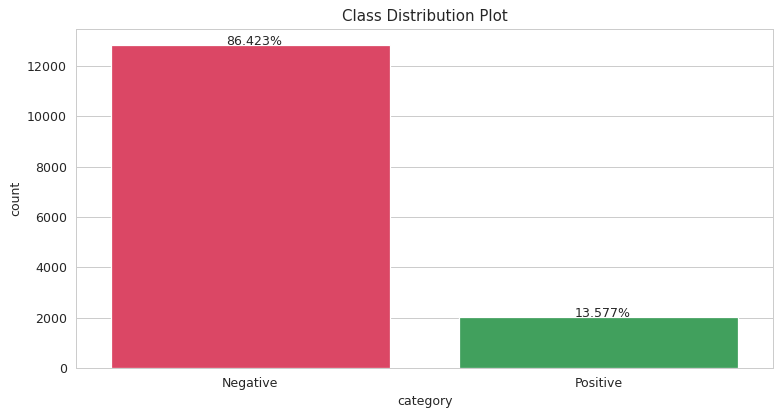

In [87]:
red_color = '#F42E56'
green_color = '#31B057'

plt.figure(figsize = [10, 5], dpi = 90)
sns.set_style('whitegrid')
sns.countplot(train['category'],
              palette = ['#F42E56', '#31B057'])
plt.xticks([0, 1], ['Negative', 'Positive'])
for index, value in enumerate([train[train['category'] == 0].shape[0], train[train['category'] == 1].shape[0]]) :
    plt.text(index-.07, value, '%.3f'%(value*100/train.shape[0]) + '%')
plt.title('Class Distribution Plot')

#### len_string_initial_plot

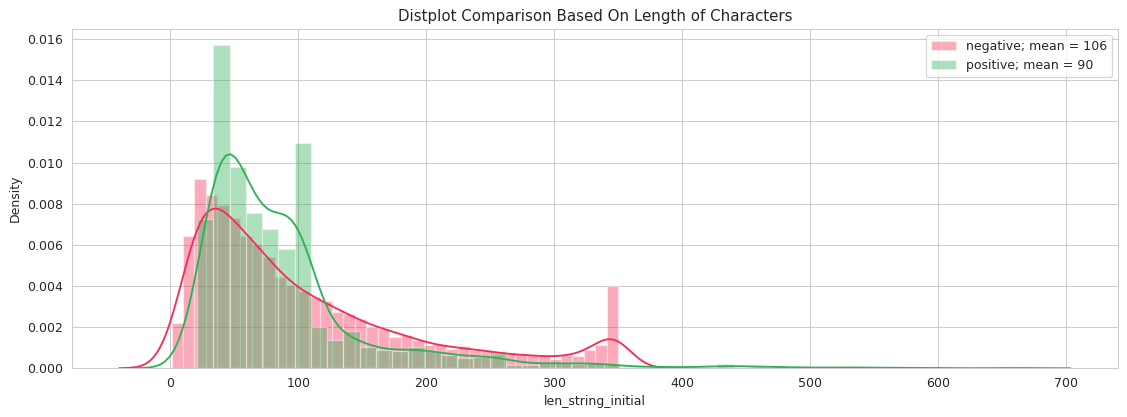

In [88]:
plt.figure(figsize = [15, 5], dpi = 90)
sns.distplot(train[train['category'] == 0]['len_string_initial'], 
             color = '#F42E56', 
             label = 'negative; mean = {mean}'.format(mean = '%.0f'%train[train['category'] == 0]['len_string_initial'].mean()))
sns.distplot(train[train['category'] == 1]['len_string_initial'], 
             color = '#31B057', 
             label = 'positive; mean = {mean}'.format(mean = '%.0f'%train[train['category'] == 1]['len_string_initial'].mean()))
plt.title('Distplot Comparison Based On Length of Characters')
plt.legend()

#### num_of_words plot

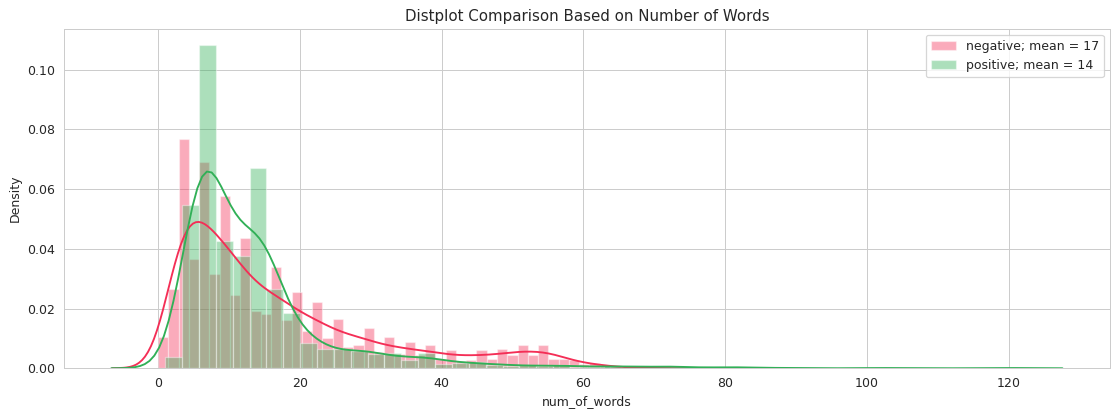

In [89]:
plt.figure(figsize = [15, 5], dpi = 90)
sns.distplot(train[train['category'] == 0]['num_of_words'], 
             color = '#F42E56', 
             label = 'negative; mean = {mean}'.format(mean = '%.0f'%train[train['category'] == 0]['num_of_words'].mean()))
sns.distplot(train[train['category'] == 1]['num_of_words'], 
             color = '#31B057', 
             label = 'positive; mean = {mean}'.format(mean = '%.0f'%train[train['category'] == 1]['num_of_words'].mean()))
plt.title('Distplot Comparison Based on Number of Words')
plt.legend()

#### num_unique_char plot

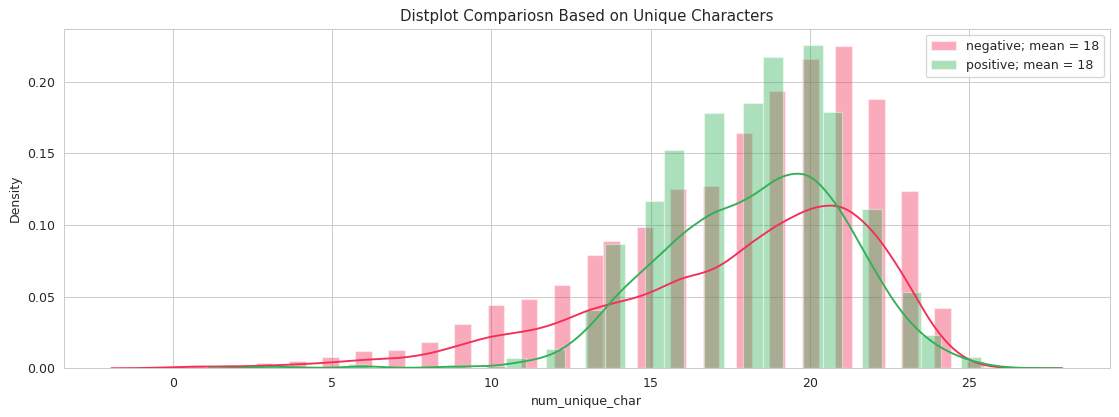

In [90]:
plt.figure(figsize = [15, 5], dpi = 90)
sns.distplot(train[train['category'] == 0]['num_unique_char'], 
             color = '#F42E56', 
             label = 'negative; mean = {mean}'.format(mean = '%.0f'%train[train['category'] == 0]['num_unique_char'].mean()))
sns.distplot(train[train['category'] == 1]['num_unique_char'], 
             color = '#31B057', 
             label = 'positive; mean = {mean}'.format(mean = '%.0f'%train[train['category'] == 1]['num_unique_char'].mean()))
plt.title('Distplot Compariosn Based on Unique Characters')
plt.legend()

#### Negative Unigram

<AxesSubplot:title={'center':'Negative Sentiment Unigram (keeping some stopwords) \n'}, xlabel='values', ylabel='words'>

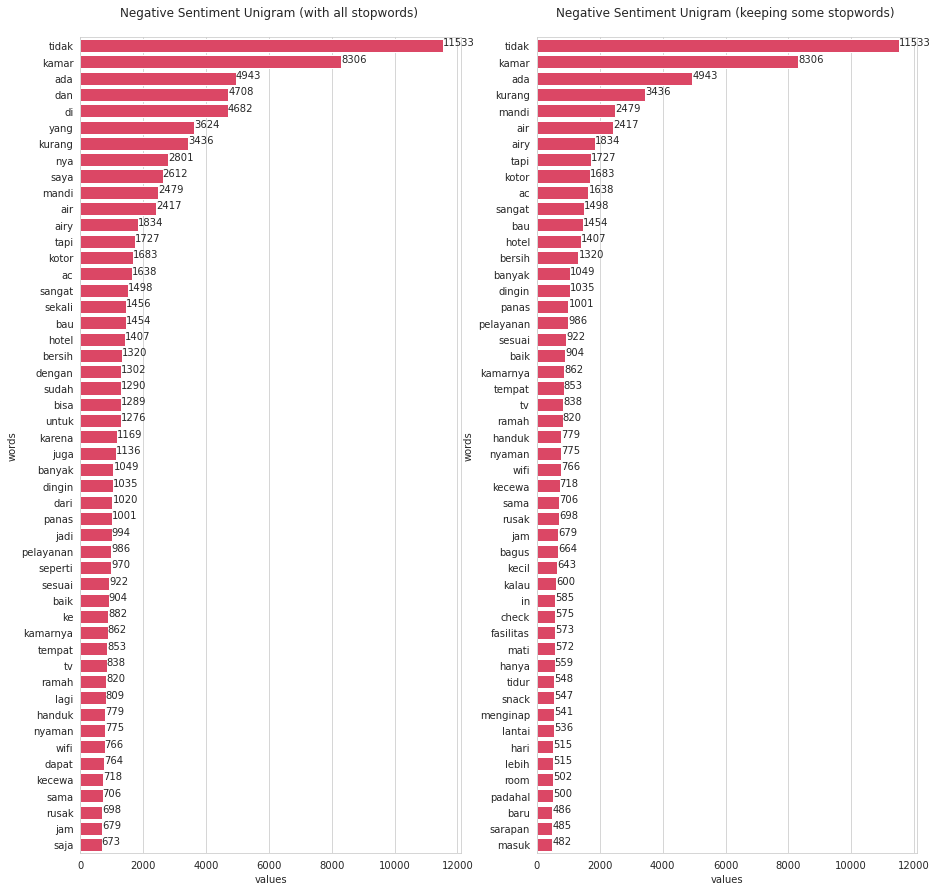

In [91]:
fig = plt.figure(figsize = [15, 15])

ax1 = fig.add_subplot(1,2,1)
#class_distribution("colname1", ax=ax1)
plot_unique_word_count(create_corpus(train[train['category'] == 0], 'review_text_cleaned'), 
                       15, 
                       18, 
                       0, 
                       50,
                       'Negative Sentiment Unigram (with all stopwords) \n',
                       '#F42E56', ax = ax1)

ax2 = fig.add_subplot(1,2,2)
plot_unique_word_count(create_corpus(train[train['category'] == 0], 'review_text_cleaned_nostopwords'), 
                       5, 
                       5, 
                       0, 
                       50,
                       'Negative Sentiment Unigram (keeping some stopwords) \n',
                       '#F42E56', ax = ax2)

stopwords like 'tidak' or the equivalent word in english 'not' are important because the meaning of a sentence could be misleading without their occurence. for example, 'not good' becomes 'good' with stopwords removal. therefore some stopwords are kept for the analysis.

#### Positive Unigram

<AxesSubplot:title={'center':'Positive Sentiment Unigram (keeping some stopwords) \n'}, xlabel='values', ylabel='words'>

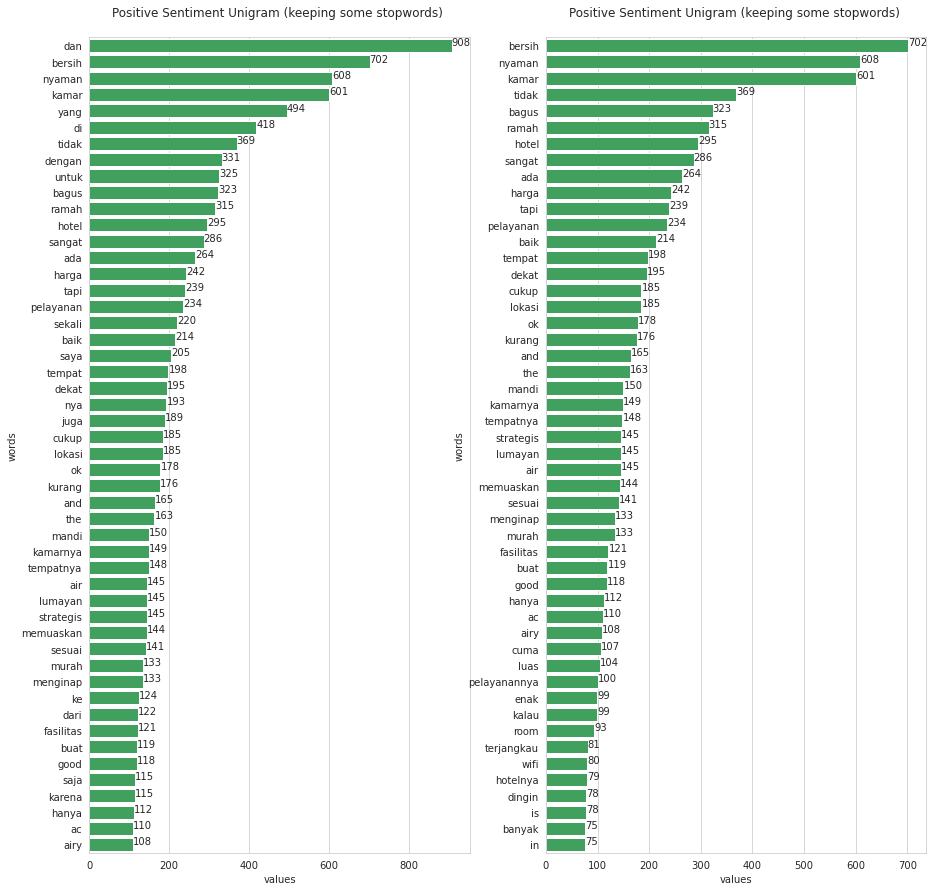

In [92]:
fig = plt.figure(figsize = [15, 15])

ax1 = fig.add_subplot(1,2,1)
#class_distribution("colname1", ax=ax1)
plot_unique_word_count(create_corpus(train[train['category'] == 1], 'review_text_cleaned'), 
                       15, 
                       18, 
                       0, 
                       50,
                       'Positive Sentiment Unigram (keeping some stopwords) \n',
                       '#31B057', ax = ax1)

ax2 = fig.add_subplot(1,2,2)
plot_unique_word_count(create_corpus(train[train['category'] == 1], 'review_text_cleaned_nostopwords'), 
                       5, 
                       5, 
                       0, 
                       50,
                       'Positive Sentiment Unigram (keeping some stopwords) \n',
                       '#31B057', ax = ax2)

#### Negative and Positive Bigrams

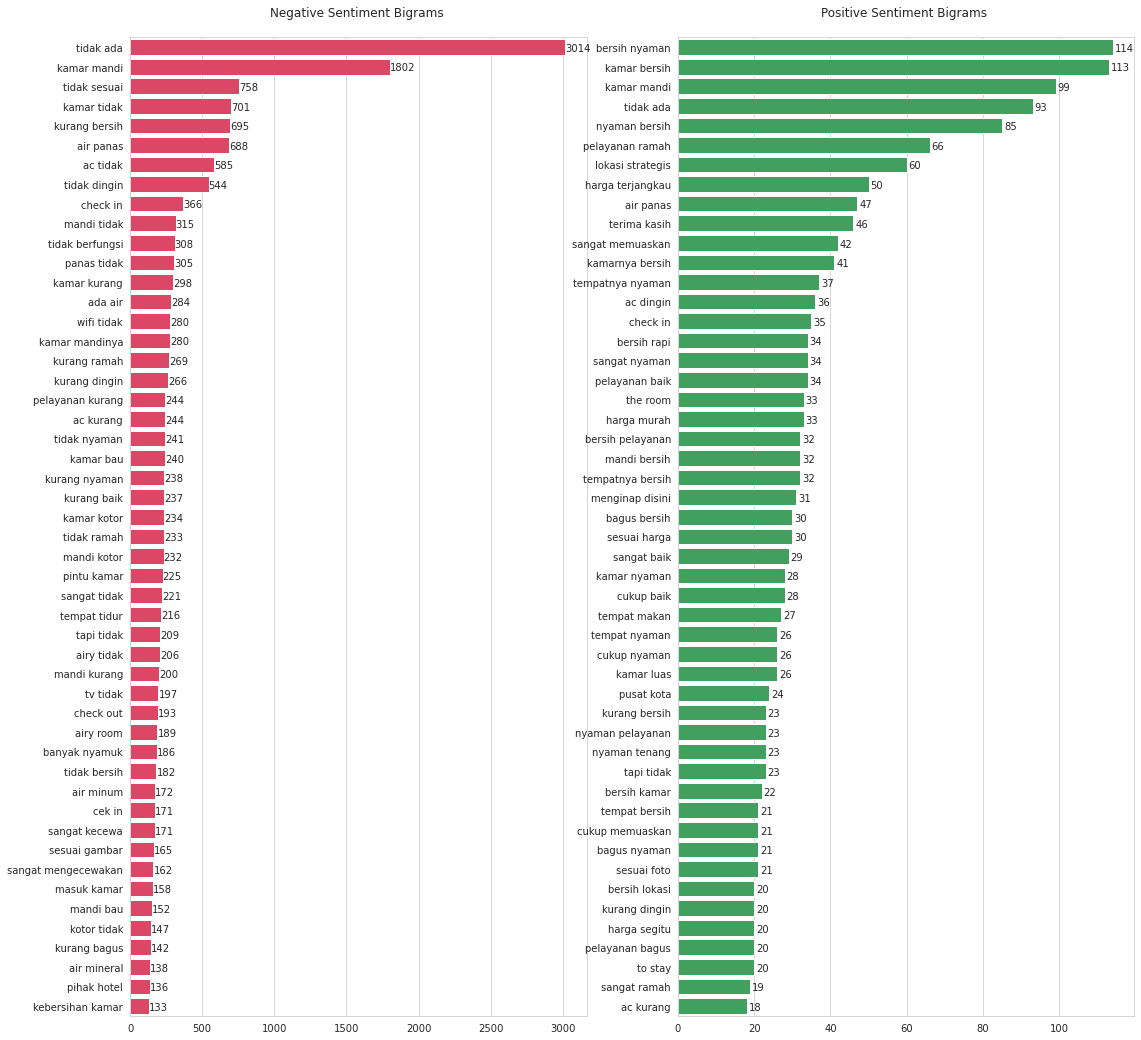

In [93]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(18,18))
top_tweet_bigrams=get_top_tweet_bigrams(train[train['category'] == 0]['review_text_cleaned_nostopwords'])[:50]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = red_color)
plt.title('Negative Sentiment Bigrams \n')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]+.5, index+.2, i[1])
    index+=1
    
top_tweet_bigrams=get_top_tweet_bigrams(train[train['category'] == 1]['review_text_cleaned_nostopwords'])[:50]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = green_color)
plt.title('Positive Sentiment Bigrams \n')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]+.5, index+.2, i[1])
    index+=1

#### Negative and Positive Trigrams

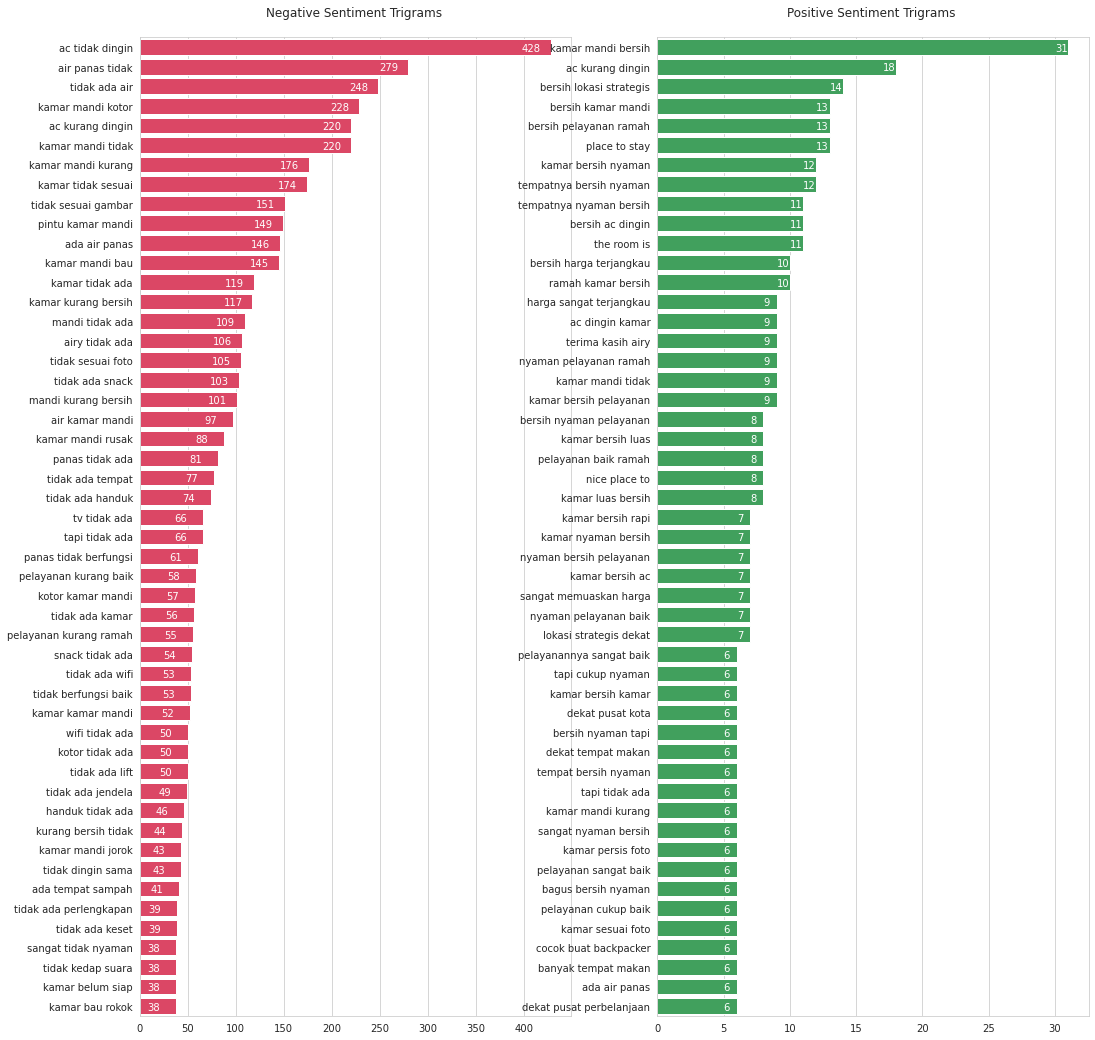

In [94]:
sns.set_style('whitegrid')
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(17,18))
top_tweet_bigrams=get_top_tweet_bigrams(train[train['category'] == 0]['review_text_cleaned_nostopwords'])[:50]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = red_color)
plt.title('Negative Sentiment Trigrams \n')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]-30, index+.2, i[1], color = 'white')
    index+=1
    
top_tweet_bigrams=get_top_tweet_bigrams(train[train['category'] == 1]['review_text_cleaned_nostopwords'])[:50]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = green_color)
plt.title('Positive Sentiment Trigrams \n')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]-1, index+.2, i[1], color = 'white')
    index+=1

#### Negative and Positive 4-grams

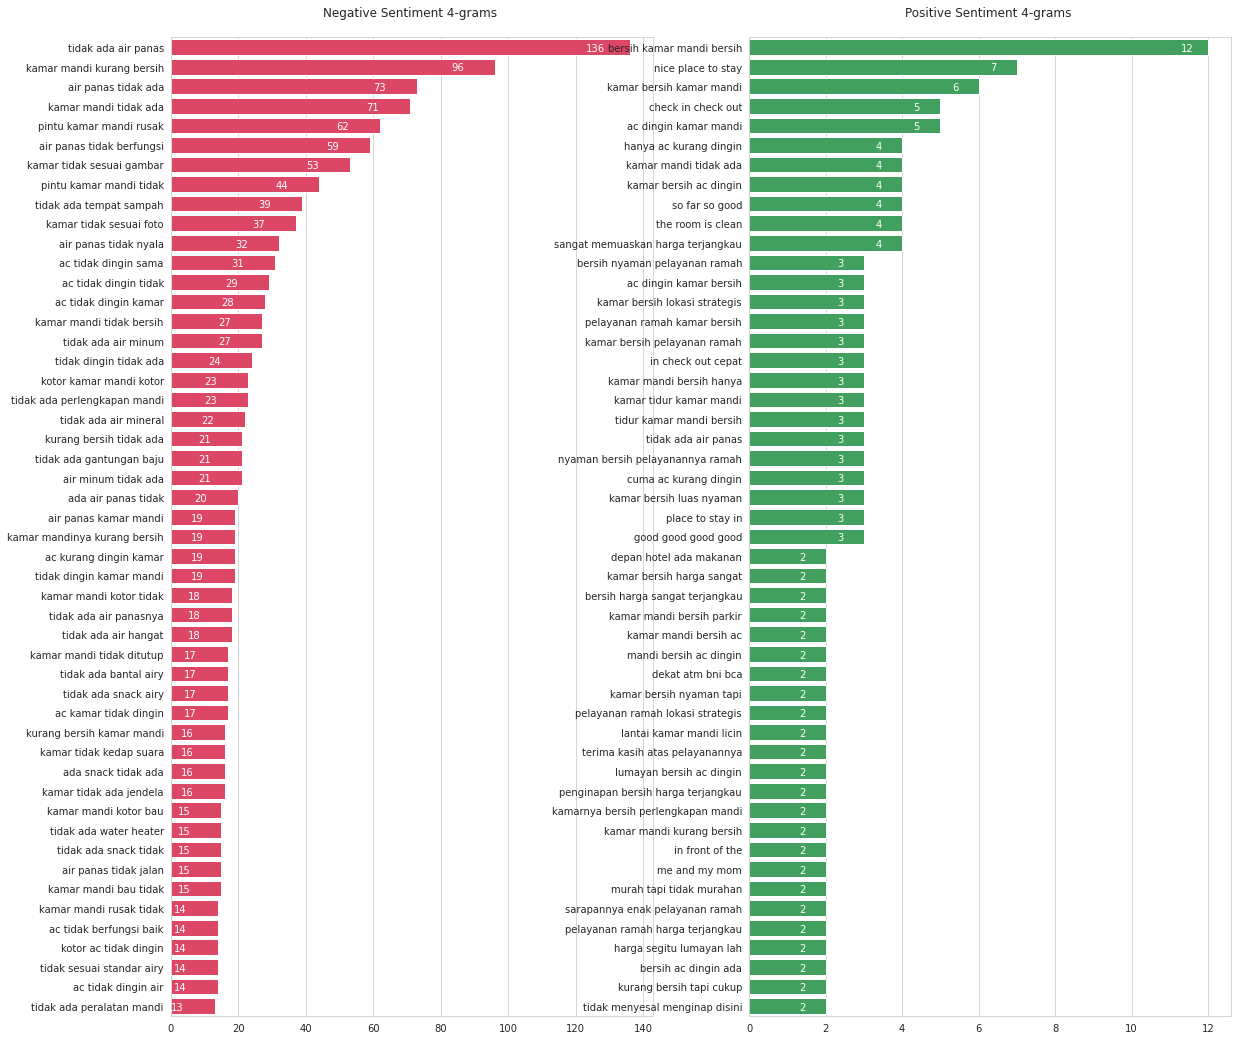

In [95]:
sns.set_style('whitegrid')
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(4, 4)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(19,18))
top_tweet_bigrams=get_top_tweet_bigrams(train[train['category'] == 0]['review_text_cleaned_nostopwords'])[:50]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = red_color)
#ax.grid(False)
plt.title('Negative Sentiment 4-grams \n')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]-13, index+.2, i[1], color = 'white')
    index+=1
    
top_tweet_bigrams=get_top_tweet_bigrams(train[train['category'] == 1]['review_text_cleaned_nostopwords'])[:50]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = green_color)
plt.title('Positive Sentiment 4-grams \n')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]-.7, index+.2, i[1], color = 'white')
    index+=1

from the previous n-grams plots, it can be concluded that comfort and cleanliness are 2 main factors that gives positive experience to customers and that's why hotels should prioritize these factors.

on the other side, many customers that have bad experience mcomplained about the unavailability of hot water facility, broken air conditioner, and dirty 

# indoBERT

Functions and classes required for the modelling

In [96]:
import string
import torch
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
#####
# Document Sentiment
#####
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'positive': 1, 'negative': 0}
    INDEX2LABEL = {1: 'positive', 0: 'negative'}
    NUM_LABELS = 2
    
    def load_dataset(self, path): 
        df = pd.read_csv(path)
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, sentiment = data['review_text'], data['category']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(sentiment), data['review_text']
    
    def __len__(self):
        return len(self.data)    
        
class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = sentiment
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, sentiment_batch, seq_list
    
# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label


def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

Modelling Initiation

In [97]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(train["review_text"], 
                                                    train['category'], train.index, stratify = train["category"],
                                                    test_size=0.25, random_state=50)

In [98]:
pd.concat([X_train,y_train],axis=1).reset_index(drop=True).to_csv("train_1.csv",index=False)

In [99]:
pd.concat([train[["review_text"]],train[['category']]], axis=1).reset_index(drop=True).to_csv("all_1.csv",index=False)

In [100]:
pd.concat([X_test,y_test],axis=1).reset_index(drop=True).to_csv("validation_1.csv",index=False)

In [101]:
import random
import torch
from torch import optim
import torch.nn.functional as F

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

In [102]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.4f}'.format(key, value))
    return ' '.join(string_list)

In [103]:
set_seed(1352)

In [104]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-large-p2")
config = BertConfig.from_pretrained("indobenchmark/indobert-large-p2")
config.num_labels = 2

# Instantiate model
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-large-p2", config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
count_param(model)

335143938

In [106]:
w2i = {"negative" : 0, "positive" : 1}
i2w = {0:"negative", 1:"positive"}

In [107]:
optimizer = optim.Adam(model.parameters(), lr=2e-6)
model = model.cuda()

In [108]:
train_dataset_path = './train_1.csv'
valid_dataset_path = "./validation_1.csv"

train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)  

In [109]:
train_loss_plot = []
valid_loss_plot = []

In [110]:
# Train
n_epochs = 4
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], 
                                                                       i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], 
                                                                       i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), 
                                                           metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    #Tracking of Loss
    train_loss_plot.append(total_train_loss/len(train_pbar))
    valid_loss_plot.append(total_loss/len(pbar))

(Epoch 1) TRAIN LOSS:0.7062 LR:0.00000200:   0%|          | 2/697 [00:01<10:39,  1.09it/s]


RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 15.90 GiB total capacity; 14.33 GiB already allocated; 9.75 MiB free; 15.02 GiB reserved in total by PyTorch)

In [ ]:
plt.figure(figsize=(12,4))
plt.title("Loss Function")
plt.plot(train_loss_plot, label="train")
plt.plot(valid_loss_plot, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss Score")
plt.legend()
plt.show()

In [ ]:
pred=[]
pred_proba=[]
for i in tqdm(range(len(test)), leave=True):
    text = test["review_text"][i]
    subwords = tokenizer.encode(text)
    subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

    logits = model(subwords)[0]
    label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
    pred.append(label)
    proba = F.softmax(logits, dim=-1).squeeze()[label] * 100
    pred_proba.append(proba.item())

In [ ]:
submission = test[["review_id"]]
submission["category"] = pred
submission["category_probs"] = pred_proba
list_to_change = submission[(submission["category"] == 1) & (submission["category_probs"] < 50)].index.tolist()
submission.iloc[list_to_change,1] = 0
submission.drop("category_probs",axis=1,inplace=True)
submission

In [ ]:
submission["category"].value_counts()

In [ ]:
submission.to_csv("submission_final.csv",index=False)

In [ ]:
# dict format {'models' : [accuracy : f1]}
val_dict = {'indoBERT base (preprocessing)' : [0.9555, 0.9041],
                   'indoBERT base (raw)' : [0.9634, 0.9170],
                   'indoBERT large (preprocessing)' : [0.9587, 0.9055],
                   'indoBERT large (raw)' : [0.9631, 0.9200],
                   'LinearSVC TF-IDF + preprocessing' : [0.942085, 0.867323],
                   'indoBERT base phase 1 pretrained' : [0.16720, 0.16045603467157965]}

val_df = pd.DataFrame(val_dict).transpose()
val_df.columns = ['accuracy', 'f1']
plt.figure(figsize = [15 ,6])
ax = sns.barplot(data = val_df.sort_values(by = 'f1', ascending = False),
            x = 'f1',
            y = val_df.sort_values(by = 'f1', ascending = False).index,
            palette = [green_color, red_color, red_color, red_color, red_color, red_color])
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xlabel('Macro F1-score')
ax.set_xticks([])
for index, value in enumerate(val_df.sort_values(by = 'f1', ascending = False)['f1']) :
    plt.text(value, index, '%.3f'%value)
plt.title('Validation Phase Comparison Between Models \n')

the previous plot is a performace-comparison plot between methods. the best model is obtained using large indoBERT using raw data (without preprocessing) and using fine tuning (without pre-trained weights). these results are obtained from other kernel.

therefore fine tuning indoBERT is used to build a classifier to classify negative and positive sentiment based on hotel review data with 0.92 macro f1-score obtained in the validation phase.